# 1. Data Collection and Cleaning

__Importing Libraries__

In [1441]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

import json
from pandas.io.json import json_normalize 

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 
from sklearn import preprocessing
import sklearn.utils
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

!conda install -c conda-forge folium=0.5.0 --yes
import folium

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

Solving environment: \ 
  - anaconda/osx-64::ca-certificates-2019.8.28-0, anaconda/osx-64::certifi-2019.9.11-py37_0, anaconda/osx-64::openssl-1.1.1d-h1de35cc_2
  - anaconda/osx-64::ca-certificates-2019.8.28-0, anaconda/osx-64::certifi-2019.9.11-py37_0, defaults/osx-64::openssl-1.1.1d-h1de35cc_2
  - anaconda/osx-64::ca-certificates-2019.8.28-0, anaconda/osx-64::openssl-1.1.1d-h1de35cc_2, defaults/osx-64::certifi-2019.9.11-py37_0
  - anaconda/osx-64::ca-certificates-2019.8.28-0, defaults/osx-64::certifi-2019.9.11-py37_0, defaults/osx-64::openssl-1.1.1d-h1de35cc_2
  - anaconda/osx-64::openssl-1.1.1d-h1de35cc_2, defaults/osx-64::ca-certificates-2019.8.28-0, defaults/osx-64::certifi-2019.9.11-py37_0
  - defaults/osx-64::ca-certificates-2019.8.28-0, defaults/osx-64::certifi-2019.9.11-py37_0, defaults/osx-64::openssl-1.1.1d-h1de35cc_2
  - anaconda/osx-64::certifi-2019.9.11-py37_0, anaconda/osx-64::openssl-1.1.1d-h1de35cc_2, defaults/osx-64::ca-certificates-2019.8.28-0
  - anaconda/osx-64::cer

__Data: Postal Codes, Boroughs and Neighbourhoods in Canada__ <br />
__Source: Wikipedia__

In [1442]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
soup = BeautifulSoup(result.content, 'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
df = df[0]

df = df[df.Borough != 'Not assigned'].reset_index(drop = True)

for i in range(df.shape[0]):
    if df.iloc[i]['Neighbourhood'] == 'Not assigned':
        df.iloc[i]['Neighbourhood'] = df.iloc[i]['Borough']
        
new_df = pd.DataFrame(columns = {})
new_df = new_df.append(df.iloc[0])

for i in range(1, df.shape[0]):
    for j in range(new_df.shape[0]):
        if df.Postcode.iloc[i] == new_df.Postcode.iloc[j]:
            new_df.Neighbourhood.iloc[j] = new_df.Neighbourhood.iloc[j] + ', ' + df.Neighbourhood.iloc[i] 
            found = 1
        else:
            found = 0
    if found == 0:
        new_df = new_df.append(df.iloc[i])
          
new_df = new_df[['Postcode', 'Borough', 'Neighbourhood']]
new_df.rename(columns={'Postcode' : 'Postal Code'}, inplace = True)
new_df

Postal Code           Borough  \
0           M3A        North York   
1           M4A        North York   
2           M5A  Downtown Toronto   
3           M6A        North York   
5           M7A  Downtown Toronto   
..          ...               ...   
192         M8X         Etobicoke   
195         M4Y  Downtown Toronto   
196         M7Y      East Toronto   
197         M8Y         Etobicoke   
205         M8Z         Etobicoke   

                                         Neighbourhood  
0                                            Parkwoods  
1                                     Victoria Village  
2                                         Harbourfront  
3                     Lawrence Heights, Lawrence Manor  
5                                         Queen's Park  
..                                                 ...  
192      The Kingsway, Montgomery Road, Old Mill North  
195                               Church and Wellesley  
196  Business Reply Mail Processing Centre 969 Eastern  
197  Humber Bay, King's Mill Park, Kingsway Park So...  
205  Kingsway Park South West, Mimico NW, The Queen...  

[103 rows x 3 columns]

__Data: Postal Codes, and geographical locations in Toronto, Ontario__ <br />
__Source: Coursera (CognitiveClass.ai)__

In [1443]:
data = pd.read_csv('https://cocl.us/Geospatial_data')   
data

Postal Code   Latitude  Longitude
0           M1B  43.806686 -79.194353
1           M1C  43.784535 -79.160497
2           M1E  43.763573 -79.188711
3           M1G  43.770992 -79.216917
4           M1H  43.773136 -79.239476
..          ...        ...        ...
98          M9N  43.706876 -79.518188
99          M9P  43.696319 -79.532242
100         M9R  43.688905 -79.554724
101         M9V  43.739416 -79.588437
102         M9W  43.706748 -79.594054

[103 rows x 3 columns]

__Joining the previous two data sources__

In [1444]:
Toronto_df = new_df.join(data.set_index('Postal Code'), on='Postal Code').reset_index(drop = True)
Toronto_df

Postal Code           Borough  \
0           M3A        North York   
1           M4A        North York   
2           M5A  Downtown Toronto   
3           M6A        North York   
4           M7A  Downtown Toronto   
..          ...               ...   
98          M8X         Etobicoke   
99          M4Y  Downtown Toronto   
100         M7Y      East Toronto   
101         M8Y         Etobicoke   
102         M8Z         Etobicoke   

                                         Neighbourhood   Latitude  Longitude  
0                                            Parkwoods  43.753259 -79.329656  
1                                     Victoria Village  43.725882 -79.315572  
2                                         Harbourfront  43.654260 -79.360636  
3                     Lawrence Heights, Lawrence Manor  43.718518 -79.464763  
4                                         Queen's Park  43.662301 -79.389494  
..                                                 ...        ...        ...  
98       The Kingsway, Montgomery Road, Old Mill North  43.653654 -79.506944  
99                                Church and Wellesley  43.665860 -79.383160  
100  Business Reply Mail Processing Centre 969 Eastern  43.662744 -79.321558  
101  Humber Bay, King's Mill Park, Kingsway Park So...  43.636258 -79.498509  
102  Kingsway Park South West, Mimico NW, The Queen...  43.628841 -79.520999  

[103 rows x 5 columns]

__Data: The population in each Neighbourhood in Canada in 2016 <br /> 
Source: Canada Stats <br />
(NOTE) This is the most recent population data set so I will be using it instead of the current population (2020)__

In [1445]:
Toronto_pop = pd.read_csv('Data/Toronto_pop.csv')
Toronto_pop.head()

Geographic code Geographic name      Province or territory  \
0              01          Canada                        NaN   
1             A0A             A0A  Newfoundland and Labrador   
2             A0B             A0B  Newfoundland and Labrador   
3             A0C             A0C  Newfoundland and Labrador   
4             A0E             A0E  Newfoundland and Labrador   

  Incompletely enumerated Indian reserves and Indian settlements, 2016  \
0                                                  T                     
1                                                NaN                     
2                                                NaN                     
3                                                NaN                     
4                                                NaN                     

   Population, 2016  Total private dwellings, 2016  \
0        35151728.0                     15412443.0   
1           46587.0                        26155.0   
2           19792.0                        13658.0   
3           12587.0                         8010.0   
4           22294.0                        12293.0   

   Private dwellings occupied by usual residents, 2016  
0                                         14072079.0    
1                                            19426.0    
2                                             8792.0    
3                                             5606.0    
4                                             9603.0

__Narrowing down the data to only include the population in neighbourhoods in Toronto, Ontario. <br />
(NOTE) There are only 102 postal codes here as opposed to 103 in the Toronto_df data. That means the population data for one neighbourhood doesn't exist.__

In [1446]:
Toronto_pop = Toronto_pop[['Geographic code','Province or territory', 'Population, 2016']]
Toronto_pop.rename(columns = {'Geographic code' : 'Postal Code'}, inplace = True)
Toronto_pop=Toronto_pop[(Toronto_pop['Province or territory'] == "Ontario")].reset_index(drop=True)
Toronto_pop = Toronto_pop[Toronto_pop['Postal Code'].str.startswith('M')].reset_index(drop=True)
Toronto_pop

Postal Code Province or territory  Population, 2016
0           M1B               Ontario           66108.0
1           M1C               Ontario           35626.0
2           M1E               Ontario           46943.0
3           M1G               Ontario           29690.0
4           M1H               Ontario           24383.0
..          ...                   ...               ...
97          M9N               Ontario           25074.0
98          M9P               Ontario           20874.0
99          M9R               Ontario           33743.0
100         M9V               Ontario           55959.0
101         M9W               Ontario           40684.0

[102 rows x 3 columns]

__The postal code M7R doesn't exist in Toronto_pop but it exists in Toronto_df__

In [1447]:
Toronto_pop[Toronto_pop['Postal Code'] == 'M7R']

Empty DataFrame
Columns: [Postal Code, Province or territory, Population, 2016]
Index: []

In [1448]:
Toronto_df[Toronto_df['Postal Code'] == 'M7R']

Postal Code      Borough                          Neighbourhood   Latitude  \
76         M7R  Mississauga  Canada Post Gateway Processing Centre  43.636966   

    Longitude  
76 -79.615819

__Now, let's join the population data with the Toronto_df data__

In [1449]:
Toronto_df = Toronto_df.join(Toronto_pop.set_index('Postal Code'), on='Postal Code').reset_index(drop = True)
Toronto_df.drop('Province or territory', axis = 1, inplace = True)
Toronto_df.dropna(inplace=True)
Toronto_df

Postal Code           Borough  \
0           M3A        North York   
1           M4A        North York   
2           M5A  Downtown Toronto   
3           M6A        North York   
4           M7A  Downtown Toronto   
..          ...               ...   
98          M8X         Etobicoke   
99          M4Y  Downtown Toronto   
100         M7Y      East Toronto   
101         M8Y         Etobicoke   
102         M8Z         Etobicoke   

                                         Neighbourhood   Latitude  Longitude  \
0                                            Parkwoods  43.753259 -79.329656   
1                                     Victoria Village  43.725882 -79.315572   
2                                         Harbourfront  43.654260 -79.360636   
3                     Lawrence Heights, Lawrence Manor  43.718518 -79.464763   
4                                         Queen's Park  43.662301 -79.389494   
..                                                 ...        ...        ...   
98       The Kingsway, Montgomery Road, Old Mill North  43.653654 -79.506944   
99                                Church and Wellesley  43.665860 -79.383160   
100  Business Reply Mail Processing Centre 969 Eastern  43.662744 -79.321558   
101  Humber Bay, King's Mill Park, Kingsway Park So...  43.636258 -79.498509   
102  Kingsway Park South West, Mimico NW, The Queen...  43.628841 -79.520999   

     Population, 2016  
0             34615.0  
1             14443.0  
2             41078.0  
3             21048.0  
4                10.0  
..                ...  
98            10787.0  
99            30472.0  
100              10.0  
101           21299.0  
102           17038.0  

[102 rows x 6 columns]

__Checking if there are any duplicates__

In [1450]:
Toronto_df[Toronto_df['Neighbourhood'].duplicated()]

Empty DataFrame
Columns: [Postal Code, Borough, Neighbourhood, Latitude, Longitude, Population, 2016]
Index: []

__Visualizing the locations of the 103 neighbourhoods in Toronto on a map__

In [1451]:
address = 'Toronto, Ontario'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Ontario are {}, {}.'.format(latitude, longitude))

/Users/mohab1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


The geograpical coordinate of Toronto, Ontario are 43.653963, -79.387207.


In [1452]:
map_Toronto_Ontario = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Borough'], df_merged['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto_Ontario)  

map_Toronto_Ontario

__Data: The geographical boundaries for each neighbourhood in Toronto, Ontario <br /> 
Source: Canada Stats__

In [1453]:
Toronto_geo = 'Data/Toronto_geo.geojson'

__Foursquare credentials__

In [1454]:
CLIENT_ID = 'DCFSCS0V02LYBBYV3K5ILCWJHPJNGIAZQHKECTF0PPKQVBUP' # your Foursquare ID
CLIENT_SECRET = 'KBJM2SSNVT1I2VUC3F4OJDDSLVXLOHQAVCNC0YRXDKZ4EVYF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DCFSCS0V02LYBBYV3K5ILCWJHPJNGIAZQHKECTF0PPKQVBUP
CLIENT_SECRET:KBJM2SSNVT1I2VUC3F4OJDDSLVXLOHQAVCNC0YRXDKZ4EVYF


__Searching all venues (using intent = browse, Limit = 1000 and radius = 1000 m) in each Neighbourhood in Toronto, Ontario <br />
Data: Venues' IDs, names, locations, distances from the corresponding Neighbourhood centre location, postal codes and categories type  <br /> 
Source: Foursquare API__

In [1455]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
def get_postal_code(row):
    try:
        postal_code = row['location']['postalCode']
    except:
        postal_code = None
        
    return postal_code
    
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 1000
    intent = 'browse'
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&intent={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            intent,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['id'],
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'], 
            v['location']['distance'],
            get_postal_code(v),
            get_category_type(v)) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue_ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Distance',
                  'Postal Code',
                  'Venue Category']
    
    return(nearby_venues)

In [1456]:
#Toronto_venues = getNearbyVenues(names=Toronto_df['Neighbourhood'],
#                                   latitudes=Toronto_df['Latitude'],
#                                   longitudes=Toronto_df['Longitude'],
#                                    radius = 1000
#                                  )

__Saving the data collected above (to work on it later)__

In [1457]:
#Toronto_venues.to_csv('Toronto_venues.csv', index = False)

__Reading the same data__

In [1458]:
Toronto_venues = pd.read_csv('Toronto_venues.csv')

In [1459]:
Toronto_venues

Neighbourhood  \
0                                              Parkwoods   
1                                              Parkwoods   
2                                              Parkwoods   
3                                              Parkwoods   
4                                              Parkwoods   
...                                                  ...   
10777  Kingsway Park South West, Mimico NW, The Queen...   
10778  Kingsway Park South West, Mimico NW, The Queen...   
10779  Kingsway Park South West, Mimico NW, The Queen...   
10780  Kingsway Park South West, Mimico NW, The Queen...   
10781  Kingsway Park South West, Mimico NW, The Queen...   

       Neighborhood Latitude  Neighborhood Longitude  \
0                  43.753259              -79.329656   
1                  43.753259              -79.329656   
2                  43.753259              -79.329656   
3                  43.753259              -79.329656   
4                  43.753259              -79.329656   
...                      ...                     ...   
10777              43.628841              -79.520999   
10778              43.628841              -79.520999   
10779              43.628841              -79.520999   
10780              43.628841              -79.520999   
10781              43.628841              -79.520999   

                       Venue_ID                      Venue  Venue Latitude  \
0      4e8d9dcdd5fbbbb6b3003c7b            Brookbanks Park       43.751976   
1      4e42684718a8627fce453c01             TTC stop #8380       43.752672   
2      5e111e7e9316a70007fb9653                     Subway       43.760334   
3      55bbdfb9498e5996dd9d4038                  Dollarama       43.760341   
4      4b26adc3f964a5205f7f24e3                Food Basics       43.760865   
...                         ...                        ...             ...   
10777  4b2badc0f964a5200db924e3      Islington Convenience       43.634401   
10778  58a730e99f25833c39ca2863         Viryl Technologies       43.627911   
10779  50e5d52de4b08e9f46b9ac82  Toronto Animal Eye Clinic       43.633949   
10780  52989ccd498ea48244e991f6           Queensway Dental       43.623633   
10781  5761891f498e158c42eccbff       Lipson Shirt Factory       43.633548   

       Venue Longitude  Distance     Venue Category  
0           -79.332140       245               Park  
1           -79.326351       273           Bus Stop  
2           -79.326906       818     Sandwich Place  
3           -79.325519       855     Discount Store  
4           -79.326015       895        Supermarket  
...                ...       ...                ...  
10777       -79.519481       630  Convenience Store  
10778       -79.526154       428        Record Shop  
10779       -79.520789       568        Pet Service  
10780       -79.515976       707   Dentist's Office  
10781       -79.524703       603  Industrial Estate  

[10782 rows x 9 columns]

In [1460]:
Toronto_venues.shape

(10782, 9)

__Checking for Null values. The postal codes contains many Null values so the entire column will be dropped. The other Null values are few so the rows will be dropped for thoses__

In [1461]:
Toronto_venues.isnull().sum()

Neighbourhood             0
Neighborhood Latitude     0
Neighborhood Longitude    0
Venue_ID                  0
Venue                     0
Venue Latitude            0
Venue Longitude           0
Distance                  0
Venue Category            0
dtype: int64

__Drop the Postal Code column__

In [1462]:
#Toronto_venues.drop(['Postal Code'], axis = 1, inplace = True)

__Dropping the other rows that contain Null values__

In [1463]:
Toronto_venues.dropna(inplace=True)

In [1464]:
Toronto_venues.shape

(10782, 9)

__Selecting only the venues that has the word "Restaurant" in the venues category column. That gives us 902 Restaurants__

In [1465]:
Toronto_restaurants = Toronto_venues[Toronto_venues['Venue Category'].str.contains("Restaurant")].reset_index(drop=True)
Toronto_restaurants

Neighbourhood  Neighborhood Latitude  \
0                                            Parkwoods              43.753259   
1                                            Parkwoods              43.753259   
2                                            Parkwoods              43.753259   
3                                            Parkwoods              43.753259   
4                                            Parkwoods              43.753259   
..                                                 ...                    ...   
897  Business Reply Mail Processing Centre 969 Eastern              43.662744   
898  Kingsway Park South West, Mimico NW, The Queen...              43.628841   
899  Kingsway Park South West, Mimico NW, The Queen...              43.628841   
900  Kingsway Park South West, Mimico NW, The Queen...              43.628841   
901  Kingsway Park South West, Mimico NW, The Queen...              43.628841   

     Neighborhood Longitude                  Venue_ID  \
0                -79.329656  58a8dcaa6119f47b9a94dc05   
1                -79.329656  4c729f4aad69b60c81ee83b9   
2                -79.329656  4b8991cbf964a520814232e3   
3                -79.329656  4c0150f4716bc9b65b9dbb55   
4                -79.329656  4e6696b6d16433b9ffff47c3   
..                      ...                       ...   
897              -79.321558  590941429de23b6c428b1d70   
898              -79.520999  4aec9552f964a52007c921e3   
899              -79.520999  509ee7d8e4b03075378182a4   
900              -79.520999  4c6d5881e13db60c516ed8b1   
901              -79.520999  4beb20e1a9900f4729691740   

                         Venue  Venue Latitude  Venue Longitude  Distance  \
0                          A&W       43.760643       -79.326865       852   
1                     Allwyn's       43.761000       -79.325478       924   
2              Allwyn's Bakery       43.759840       -79.324719       833   
3          Spicy Chicken House       43.760639       -79.325671       881   
4                          KFC       43.754387       -79.333021       298   
..                         ...             ...              ...       ...   
897    UberEATS Pop-Up Kitchen       43.664510       -79.325200       353   
898                 McDonald's       43.630017       -79.518037       272   
899        Ricco's Plum Tomato       43.632760       -79.518120       494   
900  Lakeshore Super Submarine       43.627321       -79.529354       694   
901                      Babaz       43.634295       -79.519504       618   

           Venue Category  
0    Fast Food Restaurant  
1    Caribbean Restaurant  
2    Caribbean Restaurant  
3      Chinese Restaurant  
4    Fast Food Restaurant  
..                    ...  
897      Theme Restaurant  
898  Fast Food Restaurant  
899    Italian Restaurant  
900  Fast Food Restaurant  
901  Fast Food Restaurant  

[902 rows x 9 columns]

__Since some neighbourhoods are close to each other (or to be specific, they are closer than 1000 m which is the radius indicated in the search query for venues using the Foursquare API), there are duplicates in the resturants that we got. They are not many though.__

In [1466]:
print(Toronto_restaurants.shape[0])
print(Toronto_restaurants[['Venue','Venue Latitude', 'Venue Longitude']].drop_duplicates().shape[0])

902
894


__Checking the duplicates__

In [1467]:
Toronto_restaurants[Toronto_restaurants[['Venue', 'Venue Latitude', 'Venue Longitude']].duplicated()]

Neighbourhood  Neighborhood Latitude  \
631                        Westmount              43.696319   
633                        Westmount              43.696319   
635                        Westmount              43.696319   
637                        Westmount              43.696319   
823  Stn A PO Boxes 25 The Esplanade              43.646435   
824  Stn A PO Boxes 25 The Esplanade              43.646435   
825  Stn A PO Boxes 25 The Esplanade              43.646435   
827  Stn A PO Boxes 25 The Esplanade              43.646435   

     Neighborhood Longitude                  Venue_ID  \
631              -79.532242  58fe61c1f79faa099b9ca414   
633              -79.532242  518197ee498e034fb85dc39c   
635              -79.532242  4d259c201d9fa1cd40094109   
637              -79.532242  4b96bc26f964a5201de134e3   
823              -79.374846  4b56a44ff964a5206e1728e3   
824              -79.374846  4ada4b1ef964a520022121e3   
825              -79.374846  4ad4c05df964a52055f620e3   
827              -79.374846  4c0690630ed3c9288035787d   

                                    Venue  Venue Latitude  Venue Longitude  \
631                          Jerk Delight       43.703430       -79.526017   
633  sugar and spice Caribbean restaurant       43.703308       -79.526054   
635                             Jerk king       43.701816       -79.522682   
637            Peter Anan Thai Restaurant       43.701720       -79.521411   
823  The Keg Steakhouse + Bar - Esplanade       43.646712       -79.374768   
824             The Old Spaghetti Factory       43.646964       -79.374403   
825                  Bier Markt Esplanade       43.647236       -79.373892   
827                             Takesushi       43.647114       -79.374356   

     Distance        Venue Category  
631       936  Caribbean Restaurant  
633       923  Caribbean Restaurant  
635       983  Caribbean Restaurant  
637      1058       Thai Restaurant  
823        31            Restaurant  
824        68    Italian Restaurant  
825       117    Belgian Restaurant  
827        85   Japanese Restaurant

__As expected, Neighbourhoods like Weston and Westmount are close to each other so they gave resulted in the same venue in each__

In [1468]:
Toronto_restaurants[Toronto_restaurants['Venue'] == 'Jerk Delight']

Neighbourhood  Neighborhood Latitude  Neighborhood Longitude  \
596        Weston              43.706876              -79.518188   
631     Westmount              43.696319              -79.532242   

                     Venue_ID         Venue  Venue Latitude  Venue Longitude  \
596  58fe61c1f79faa099b9ca414  Jerk Delight        43.70343       -79.526017   
631  58fe61c1f79faa099b9ca414  Jerk Delight        43.70343       -79.526017   

     Distance        Venue Category  
596       737  Caribbean Restaurant  
631       936  Caribbean Restaurant

__Removing duplicates. It doesn't matter much from which neighbourhood they should be removed because the neighbourhoods are close to each other__

In [1469]:
Toronto_restaurants.drop_duplicates(subset =['Venue','Venue Latitude', 'Venue Longitude'], inplace=True)

__Now there are 894 Restaurants__

In [1470]:
print(Toronto_restaurants.shape[0])

894


__Getting details about each of the 894 Restaurants Toronto, Ontario <br />
Data: Restaurants' ratings, likes, checkins, price tier and tips  <br /> 
Source: Foursquare API__ <br />
__(NOTE) There are 894 Restaurants and this a premium call (there are only 500 calls allowed per day). So, the data was collected and appended over two days__

In [1471]:
def get_rating(row):
    try:
        rating = row['rating']
    except:
        rating = None        
    return rating

def get_likes(row):
    try:
        likes = row['likes']['count']
    except:
        likes = None        
    return likes

def get_checkins(row):
    try:
        checkins = row['stats']['checkinsCount']
    except:
        checkins = None        
    return checkins

def get_price(row):
    try:
        price = row['price']['tier']
    except:
        price = None        
    return price

def get_tips(row):
    try:
        tips = row['tips']['count']
    except:
        tips = None        
    return tips
    
def get_venue_details(Venue_ID):
    venues_list=[]
    for venue_id in Venue_ID:
        print('. ')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venue']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            venue_id, 
            get_rating(results), 
            get_likes(results),
            get_checkins(results),
            get_price(results), 
            get_tips(results))])

    venues_details = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues_details.columns = ['Venue_ID', 
                             'Rating',
                             'Likes',
                             'CheckIns',
                             'Price',
                             'Tips']
                            
    
    return(venues_details)

__Collecting the restaurants' details over two days by dividing the data into two sections: [0:450] and [450:894]__

In [1472]:
Toronto_restaurants_details = pd.DataFrame({})

In [1473]:
#Toronto_restaurants_details = Toronto_restaurants_details.append(get_venue_details(Toronto_restaurants['Venue_ID'].iloc[450:894])).reset_index(drop=True)

__Saving the data collected above so that it can be used later__

In [1474]:
#Toronto_restaurants_details.to_csv('Toronto_restaurants_details.csv', index = False)

__Reading the same data above__

In [1475]:
Toronto_restaurants_details = pd.read_csv('Toronto_restaurants_details.csv')

In [1476]:
Toronto_restaurants_details

Venue_ID  Rating  Likes  CheckIns  Price  Tips
0    58a8dcaa6119f47b9a94dc05     6.8      6       NaN    1.0     1
1    4c729f4aad69b60c81ee83b9     NaN      1       NaN    2.0     2
2    4b8991cbf964a520814232e3     8.8     18       NaN    2.0    16
3    4c0150f4716bc9b65b9dbb55     NaN      1       NaN    1.0     4
4    4e6696b6d16433b9ffff47c3     NaN      0       NaN    1.0     0
..                        ...     ...    ...       ...    ...   ...
889  590941429de23b6c428b1d70     NaN      0       NaN    NaN     0
890  4aec9552f964a52007c921e3     6.0     24       NaN    1.0     5
891  509ee7d8e4b03075378182a4     NaN      0       NaN    2.0     0
892  4c6d5881e13db60c516ed8b1     NaN      0       NaN    1.0     0
893  4beb20e1a9900f4729691740     NaN      0       NaN    1.0     0

[894 rows x 6 columns]

__Checking for Null values. It seems that all the checkins values are Null so this column will be dropped. Also there are many Null values in the ratings column and a few Null values in the likes column. Let's explore them to decide what can be done.__ 

In [1477]:
Toronto_restaurants_details.isnull().sum()

Venue_ID      0
Rating      648
Likes         0
CheckIns    894
Price        37
Tips          0
dtype: int64

In [1478]:
Toronto_restaurants_details.drop(['CheckIns'], axis = 1, inplace = True)

Text(0, 0.5, 'Counts')

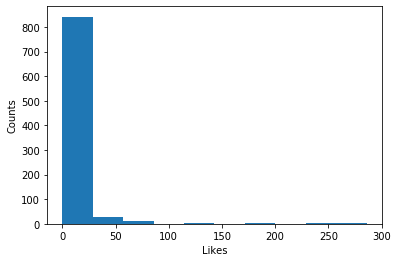

In [1479]:
plt.hist(Toronto_restaurants_details['Likes'], bins = 10)
plt.xlabel('Likes')
plt.ylabel('Counts')

/Users/mohab1/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mohab1/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Counts')

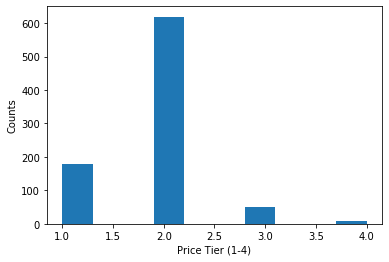

In [1480]:
plt.hist(Toronto_restaurants_details['Price'], bins = 10)
plt.xlabel('Price Tier (1-4)')
plt.ylabel('Counts')

__It seems that the majority of the price tier has a value of 2.0. So the few Null values in the price tier will be replaced by 2.0.__

In [1481]:
Toronto_restaurants_details['Price'].fillna(value = 2.0, inplace = True)

Text(0, 0.5, 'Counts')

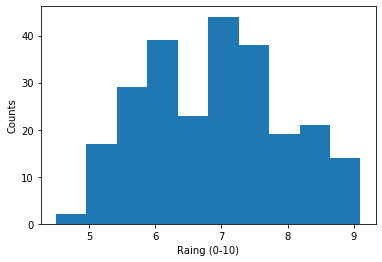

In [1482]:
plt.hist(Toronto_restaurants_details['Rating'], bins = 10)
plt.xlabel('Raing (0-10)')
plt.ylabel('Counts')

__Since there are many Null values in the ratings and we can not just assign them to zero, they need to be replaced by a meaningful value. So let's try to explore any relation between the rating and other features (example: Likes).__

In [1483]:
temp = Toronto_restaurants_details[~Toronto_restaurants_details['Rating'].isnull()].reset_index(drop=True)
temp

Venue_ID  Rating  Likes  Price  Tips
0    58a8dcaa6119f47b9a94dc05     6.8      6    1.0     1
1    4b8991cbf964a520814232e3     8.8     18    2.0    16
2    4f3ecce6e4b0587016b6f30d     6.0      5    2.0    12
3    5ab3d9f875a6ea3a7ddc4d2b     6.3      0    2.0     0
4    4ee0c52fd3e38ddb2afea856     5.8      0    1.0     0
..                        ...     ...    ...    ...   ...
241  58f8e273e96d0c5eae0ab3b0     6.3     27    2.0     5
242  58659c5703e29a1f502e034c     7.0     15    2.0     4
243  4b65b9f1f964a520fefb2ae3     5.2     18    1.0    13
244  4ad9ebdcf964a520e61b21e3     6.8     10    1.0     9
245  4aec9552f964a52007c921e3     6.0     24    1.0     5

[246 rows x 5 columns]

__Checking if there is a correlation between the ratings and likes__

Likes    Rating
Likes   1.000000  0.449923
Rating  0.449923  1.000000

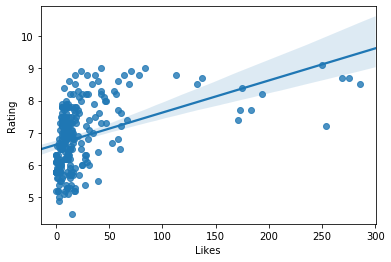

In [1484]:
sns.regplot(x="Likes", y="Rating", data=temp)
temp[["Likes", "Rating"]].corr()

__Removing outliers to see if the correlation improves__

Likes    Rating
Likes   1.000000  0.496571
Rating  0.496571  1.000000

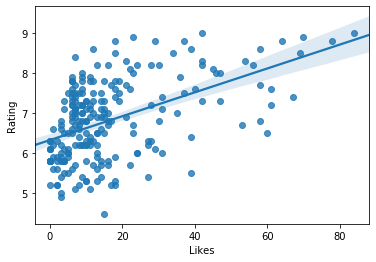

In [1485]:
temp = temp[temp['Likes']<100]
sns.regplot(x="Likes", y="Rating", data=temp)
temp[["Likes", "Rating"]].corr()

In [1486]:
x_train, x_test, y_train, y_test = train_test_split(temp[['Likes']], temp[['Rating']], test_size=0.2, random_state=0)

__R2 is very low, so we can't trust this model__

In [1487]:
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
regr.score(x_train, y_train)

0.25085783794173055

In [1488]:
yhat = regr.predict(x_test)
r2_score(yhat, y_test)

-0.5704366400615548

__Since I couldn't get a good relation between rating and likes, I will assign the Null values in ratings to a uniform random distribution based on the min/max values of the given ratings (this is not accurate but it is done for the sake of this project only) <br /> 
(NOTE) Here I am assigning the entire slice of Null values to the uniform random distribution values__

In [1489]:
temp = Toronto_restaurants_details[~Toronto_restaurants_details['Rating'].isnull()]['Rating'].reset_index(drop=True)
Toronto_restaurants_details.loc[Toronto_restaurants_details['Rating'].isnull(), 'Rating'] = np.random.uniform(low = temp.min(), high=temp.max(), size=Toronto_restaurants_details.shape[0]-temp.shape[0])
Toronto_restaurants_details

Venue_ID    Rating  Likes  Price  Tips
0    58a8dcaa6119f47b9a94dc05  6.800000      6    1.0     1
1    4c729f4aad69b60c81ee83b9  4.627025      1    2.0     2
2    4b8991cbf964a520814232e3  8.800000     18    2.0    16
3    4c0150f4716bc9b65b9dbb55  5.876229      1    1.0     4
4    4e6696b6d16433b9ffff47c3  4.793010      0    1.0     0
..                        ...       ...    ...    ...   ...
889  590941429de23b6c428b1d70  6.385279      0    2.0     0
890  4aec9552f964a52007c921e3  6.000000     24    1.0     5
891  509ee7d8e4b03075378182a4  4.886868      0    2.0     0
892  4c6d5881e13db60c516ed8b1  5.615990      0    1.0     0
893  4beb20e1a9900f4729691740  5.051667      0    1.0     0

[894 rows x 5 columns]

Text(0, 0.5, 'Counts')

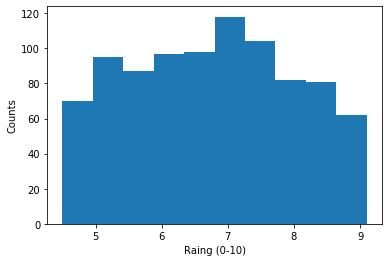

In [1490]:
plt.hist(Toronto_restaurants_details['Rating'], bins = 10)
plt.xlabel('Raing (0-10)')
plt.ylabel('Counts')

In [1491]:
#Toronto_restaurants_details['Rating'].fillna(value = Toronto_restaurants_details['Rating'].mean(), inplace = True)

__Now, let's combine the two datasets that we got from Foursquare.__

In [1492]:
Toronto_restaurants = Toronto_restaurants.join(Toronto_restaurants_details.set_index('Venue_ID'), on= 'Venue_ID').reset_index(drop=True)

In [1493]:
Toronto_restaurants

Neighbourhood  Neighborhood Latitude  \
0                                            Parkwoods              43.753259   
1                                            Parkwoods              43.753259   
2                                            Parkwoods              43.753259   
3                                            Parkwoods              43.753259   
4                                            Parkwoods              43.753259   
..                                                 ...                    ...   
889  Business Reply Mail Processing Centre 969 Eastern              43.662744   
890  Kingsway Park South West, Mimico NW, The Queen...              43.628841   
891  Kingsway Park South West, Mimico NW, The Queen...              43.628841   
892  Kingsway Park South West, Mimico NW, The Queen...              43.628841   
893  Kingsway Park South West, Mimico NW, The Queen...              43.628841   

     Neighborhood Longitude                  Venue_ID  \
0                -79.329656  58a8dcaa6119f47b9a94dc05   
1                -79.329656  4c729f4aad69b60c81ee83b9   
2                -79.329656  4b8991cbf964a520814232e3   
3                -79.329656  4c0150f4716bc9b65b9dbb55   
4                -79.329656  4e6696b6d16433b9ffff47c3   
..                      ...                       ...   
889              -79.321558  590941429de23b6c428b1d70   
890              -79.520999  4aec9552f964a52007c921e3   
891              -79.520999  509ee7d8e4b03075378182a4   
892              -79.520999  4c6d5881e13db60c516ed8b1   
893              -79.520999  4beb20e1a9900f4729691740   

                         Venue  Venue Latitude  Venue Longitude  Distance  \
0                          A&W       43.760643       -79.326865       852   
1                     Allwyn's       43.761000       -79.325478       924   
2              Allwyn's Bakery       43.759840       -79.324719       833   
3          Spicy Chicken House       43.760639       -79.325671       881   
4                          KFC       43.754387       -79.333021       298   
..                         ...             ...              ...       ...   
889    UberEATS Pop-Up Kitchen       43.664510       -79.325200       353   
890                 McDonald's       43.630017       -79.518037       272   
891        Ricco's Plum Tomato       43.632760       -79.518120       494   
892  Lakeshore Super Submarine       43.627321       -79.529354       694   
893                      Babaz       43.634295       -79.519504       618   

           Venue Category    Rating  Likes  Price  Tips  
0    Fast Food Restaurant  6.800000      6    1.0     1  
1    Caribbean Restaurant  4.627025      1    2.0     2  
2    Caribbean Restaurant  8.800000     18    2.0    16  
3      Chinese Restaurant  5.876229      1    1.0     4  
4    Fast Food Restaurant  4.793010      0    1.0     0  
..                    ...       ...    ...    ...   ...  
889      Theme Restaurant  6.385279      0    2.0     0  
890  Fast Food Restaurant  6.000000     24    1.0     5  
891    Italian Restaurant  4.886868      0    2.0     0  
892  Fast Food Restaurant  5.615990      0    1.0     0  
893  Fast Food Restaurant  5.051667      0    1.0     0  

[894 rows x 13 columns]

__Now, let's merge all the datasets into one big dataframe. There are 894 rows here.__

In [1494]:
Toronto_restaurants = Toronto_restaurants.join(Toronto_df.set_index('Neighbourhood'), on= 'Neighbourhood')
Toronto_restaurants.drop(['Latitude', 'Longitude'], axis =1, inplace = True)

In [1495]:
Toronto_restaurants

Neighbourhood  Neighborhood Latitude  \
0                                            Parkwoods              43.753259   
1                                            Parkwoods              43.753259   
2                                            Parkwoods              43.753259   
3                                            Parkwoods              43.753259   
4                                            Parkwoods              43.753259   
..                                                 ...                    ...   
889  Business Reply Mail Processing Centre 969 Eastern              43.662744   
890  Kingsway Park South West, Mimico NW, The Queen...              43.628841   
891  Kingsway Park South West, Mimico NW, The Queen...              43.628841   
892  Kingsway Park South West, Mimico NW, The Queen...              43.628841   
893  Kingsway Park South West, Mimico NW, The Queen...              43.628841   

     Neighborhood Longitude                  Venue_ID  \
0                -79.329656  58a8dcaa6119f47b9a94dc05   
1                -79.329656  4c729f4aad69b60c81ee83b9   
2                -79.329656  4b8991cbf964a520814232e3   
3                -79.329656  4c0150f4716bc9b65b9dbb55   
4                -79.329656  4e6696b6d16433b9ffff47c3   
..                      ...                       ...   
889              -79.321558  590941429de23b6c428b1d70   
890              -79.520999  4aec9552f964a52007c921e3   
891              -79.520999  509ee7d8e4b03075378182a4   
892              -79.520999  4c6d5881e13db60c516ed8b1   
893              -79.520999  4beb20e1a9900f4729691740   

                         Venue  Venue Latitude  Venue Longitude  Distance  \
0                          A&W       43.760643       -79.326865       852   
1                     Allwyn's       43.761000       -79.325478       924   
2              Allwyn's Bakery       43.759840       -79.324719       833   
3          Spicy Chicken House       43.760639       -79.325671       881   
4                          KFC       43.754387       -79.333021       298   
..                         ...             ...              ...       ...   
889    UberEATS Pop-Up Kitchen       43.664510       -79.325200       353   
890                 McDonald's       43.630017       -79.518037       272   
891        Ricco's Plum Tomato       43.632760       -79.518120       494   
892  Lakeshore Super Submarine       43.627321       -79.529354       694   
893                      Babaz       43.634295       -79.519504       618   

           Venue Category    Rating  Likes  Price  Tips Postal Code  \
0    Fast Food Restaurant  6.800000      6    1.0     1         M3A   
1    Caribbean Restaurant  4.627025      1    2.0     2         M3A   
2    Caribbean Restaurant  8.800000     18    2.0    16         M3A   
3      Chinese Restaurant  5.876229      1    1.0     4         M3A   
4    Fast Food Restaurant  4.793010      0    1.0     0         M3A   
..                    ...       ...    ...    ...   ...         ...   
889      Theme Restaurant  6.385279      0    2.0     0         M7Y   
890  Fast Food Restaurant  6.000000     24    1.0     5         M8Z   
891    Italian Restaurant  4.886868      0    2.0     0         M8Z   
892  Fast Food Restaurant  5.615990      0    1.0     0         M8Z   
893  Fast Food Restaurant  5.051667      0    1.0     0         M8Z   

          Borough  Population, 2016  
0      North York           34615.0  
1      North York           34615.0  
2      North York           34615.0  
3      North York           34615.0  
4      North York           34615.0  
..            ...               ...  
889  East Toronto              10.0  
890     Etobicoke           17038.0  
891     Etobicoke           17038.0  
892     Etobicoke           17038.0  
893     Etobicoke           17038.0  

[894 rows x 16 columns]

In [1496]:
Toronto_restaurants.isnull().sum()

Neighbourhood              0
Neighborhood Latitude      0
Neighborhood Longitude     0
Venue_ID                   0
Venue                      0
Venue Latitude             0
Venue Longitude            0
Distance                   0
Venue Category             0
Rating                     0
Likes                      0
Price                      0
Tips                       0
Postal Code               13
Borough                   13
Population, 2016          13
dtype: int64

__The Null values belong to the Postal code M7R that doesn't exist in Toronto_pop so it was removed from Toronto_df__

In [1499]:
Toronto_restaurants[Toronto_restaurants['Postal Code'].isnull()]

Neighbourhood  Neighborhood Latitude  \
687  Canada Post Gateway Processing Centre              43.636966   
688  Canada Post Gateway Processing Centre              43.636966   
689  Canada Post Gateway Processing Centre              43.636966   
690  Canada Post Gateway Processing Centre              43.636966   
691  Canada Post Gateway Processing Centre              43.636966   
692  Canada Post Gateway Processing Centre              43.636966   
693  Canada Post Gateway Processing Centre              43.636966   
694  Canada Post Gateway Processing Centre              43.636966   
695  Canada Post Gateway Processing Centre              43.636966   
696  Canada Post Gateway Processing Centre              43.636966   
697  Canada Post Gateway Processing Centre              43.636966   
698  Canada Post Gateway Processing Centre              43.636966   
699  Canada Post Gateway Processing Centre              43.636966   

     Neighborhood Longitude                  Venue_ID  \
687              -79.615819  4bb4d98cd027ef3b84cf0c9d   
688              -79.615819  56ffef04498e7ade5c82ec7b   
689              -79.615819  57963f63498e9ef3103d7875   
690              -79.615819  5baa5b9b1b0ea50039dc1ac9   
691              -79.615819  4caa04e444a8224ba9cc2640   
692              -79.615819  504c9db7e4b050eb2aa0af1a   
693              -79.615819  574dd66b498ea9fad867e730   
694              -79.615819  4bf6c05013aed13a8a23eaf7   
695              -79.615819  54c4248f498eb3a1cadc6439   
696              -79.615819  4c8e68ccd2aea0934838ce69   
697              -79.615819  4ca9fe7f2776b60cc8cb440d   
698              -79.615819  59ff7e988b98fd496c04dfbd   
699              -79.615819  4e7bb7a552b14ada7832b979   

                             Venue  Venue Latitude  Venue Longitude  Distance  \
687                         Wokker       43.634856       -79.617149       258   
688         Chipotle Mexican Grill       43.637412       -79.622280       522   
689                      Mr. Greek       43.638350       -79.622189       535   
690                   Thai Express       43.638236       -79.622005       518   
691                         Anoush       43.636769       -79.620840       405   
692     Great North American Grill       43.638429       -79.618756       287   
693                   Osmows Grill       43.638413       -79.622373       552   
694            Lemon Grass Kitchen       43.631887       -79.614548       574   
695                Veggie Paradise       43.634000       -79.617200       348   
696         Dynasty BBQ restaurant       43.631943       -79.614552       568   
697  Anoush Middle Eastern Cuisine       43.636848       -79.620770       399   
698                   Mandilicious       43.636703       -79.622804       563   
699               Canoe Restaurant       43.632629       -79.615131       485   

                    Venue Category    Rating  Likes  Price  Tips Postal Code  \
687             Chinese Restaurant  6.293041      0    1.0     0         NaN   
688             Mexican Restaurant  7.700000     17    1.0     2         NaN   
689               Greek Restaurant  8.182505      1    2.0     0         NaN   
690                Thai Restaurant  6.300000      0    2.0     0         NaN   
691       Mediterranean Restaurant  7.863323      0    2.0     0         NaN   
692            American Restaurant  7.664261      0    2.0     0         NaN   
693       Mediterranean Restaurant  6.812306      3    2.0     0         NaN   
694             Chinese Restaurant  4.699848      3    1.0     2         NaN   
695  Vegetarian / Vegan Restaurant  6.468928      1    2.0     1         NaN   
696             Chinese Restaurant  6.796236      1    1.0     3         NaN   
697      Middle Eastern Restaurant  6.560099      1    2.0     0         NaN   
698      Middle Eastern Restaurant  4.520583      2    2.0     0         NaN   
699                     Restaurant  7.501173      0    2.0     0         NaN   

    Bor

__Now we have 881 Restaurants in 99 Neighbourhoods in 9 Boroughs__

In [1519]:
Toronto_restaurants.dropna(inplace=True)
Toronto_restaurants.reset_index(drop=True)
print(Toronto_restaurants.shape[0])
print(Toronto_restaurants.groupby(by='Neighbourhood').sum().shape[0])
print(Toronto_restaurants.groupby(by='Borough').sum().shape[0])

881
99
9


# 2. Exploratory Data Analysis

__Exploring the number of restaurants in each category type or, in other words, the different cuisines__

In [1505]:
Toronto_restaurants_count = Toronto_restaurants.groupby(by='Venue Category').count()
Toronto_restaurants_count

Neighbourhood  Neighborhood Latitude  \
Venue Category                                                        
Afghan Restaurant                          3                      3   
African Restaurant                        11                     11   
American Restaurant                       20                     20   
Argentinian Restaurant                     1                      1   
Asian Restaurant                          33                     33   
...                                      ...                    ...   
Theme Restaurant                           1                      1   
Tibetan Restaurant                         2                      2   
Turkish Restaurant                         4                      4   
Vegetarian / Vegan Restaurant             16                     16   
Vietnamese Restaurant                     29                     29   

                               Neighborhood Longitude  Venue_ID  Venue  \
Venue Category                                                           
Afghan Restaurant                                   3         3      3   
African Restaurant                                 11        11     11   
American Restaurant                                20        20     20   
Argentinian Restaurant                              1         1      1   
Asian Restaurant                                   33        33     33   
...                                               ...       ...    ...   
Theme Restaurant                                    1         1      1   
Tibetan Restaurant                                  2         2      2   
Turkish Restaurant                                  4         4      4   
Vegetarian / Vegan Restaurant                      16        16     16   
Vietnamese Restaurant                              29        29     29   

                               Venue Latitude  Venue Longitude  Distance  \
Venue Category                                                             
Afghan Restaurant                           3                3         3   
African Restaurant                         11               11        11   
American Restaurant                        20               20        20   
Argentinian Restaurant                      1                1         1   
Asian Restaurant                           33               33        33   
...                                       ...              ...       ...   
Theme Restaurant                            1                1         1   
Tibetan Restaurant                          2                2         2   
Turkish Restaurant                          4                4         4   
Vegetarian / Vegan Restaurant              16               16        16   
Vietnamese Restaurant                      29               29        29   

                               Rating  Likes  Price  Tips  Postal Code  \
Venue Category                                                           
Afghan Restaurant                   3      3      3     3            3   
African Restaurant                 11     11     11    11           11   
American Restaurant                20     20     20    20           20   
Argentinian Restaurant              1      1      1     1            1   
Asian Restaurant                   33     33     33    33           33   
...                               ...    ...    ...   ...          ...   
Theme Restaurant                    1      1      1     1            1   
Tibetan Restaurant                  2      2      2     2            2   
Turkish Restaurant                  4      4      4     4            4   
Vegetarian / Vegan Restaurant      16     16     16    16           16   
Vietnamese Restaurant              29     29     29    29           29   

                               Borough  Population, 2016  
Venue Category                                            
Afghan Restaurant                    3                 3  
African Restaur

__(NOTE) the type of restaurant with the heighest count is actually generic (meaning no specific cuisine). That's fine because we will consider all of them as just restaurants (wihout considering their different cuisines)__

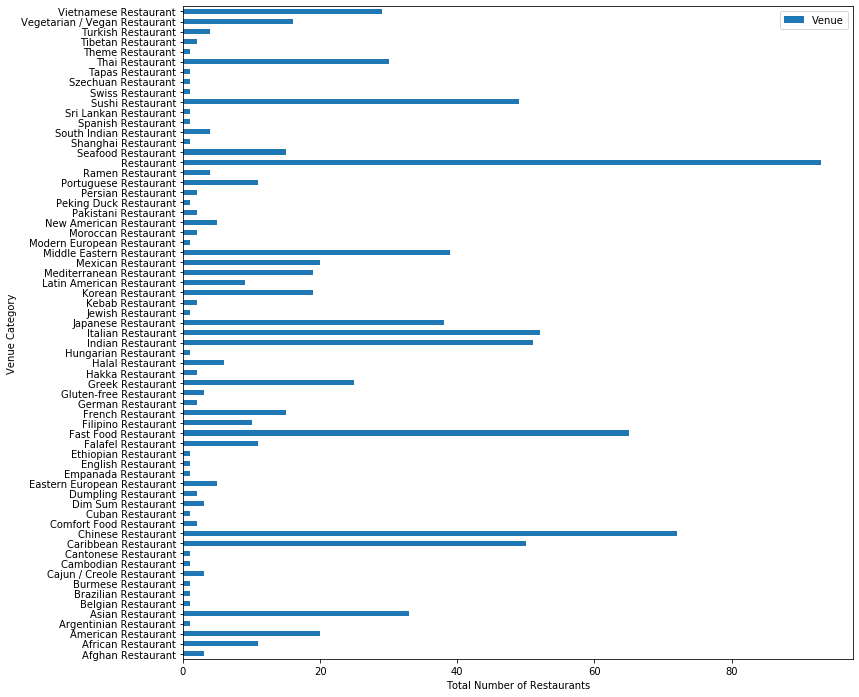

In [1506]:
Toronto_restaurants_count[['Venue']].plot(kind='barh', figsize = (12,12))
plt.xlabel('Total Number of Restaurants')
#plt.annotate('',                      
#             xy=(10, 48),           
#             xytext=(10, 0),    
#             xycoords='data',         
#             arrowprops=dict(arrowstyle='-', connectionstyle='arc3', color='red', lw=2)
#            )
plt.show()

In [136]:
#Target_restaurants = Toronto_restaurants_count[(Toronto_restaurants.groupby(by='Venue Category').count().reset_index(drop=True) >= 10).iloc[:,0].to_list()].reset_index().iloc[:,0].to_list()
#Toronto_target_restaurants = Toronto_restaurants[Toronto_restaurants['Venue Category'].isin(Target_restaurants)]
#Toronto_target_restaurants.head(10)

__Exploring the number of restaurants in each neighbourhood__

In [1507]:
Toronto_neigh_restaurants_count = Toronto_restaurants.groupby(by='Neighbourhood').count()
Toronto_neigh_restaurants_count

Neighborhood Latitude  \
Neighbourhood                                                               
Adelaide, King, Richmond                                               19   
Agincourt                                                              10   
Agincourt North, L'Amoreaux East, Milliken, Ste...                     10   
Albion Gardens, Beaumond Heights, Humbergate, J...                      4   
Alderwood, Long Branch                                                  9   
...                                                                   ...   
Willowdale West                                                         1   
Woburn                                                                 14   
Woodbine Gardens, Parkview Hill                                         9   
Woodbine Heights                                                        6   
York Mills West                                                         3   

                                                    Neighborhood Longitude  \
Neighbourhood                                                                
Adelaide, King, Richmond                                                19   
Agincourt                                                               10   
Agincourt North, L'Amoreaux East, Milliken, Ste...                      10   
Albion Gardens, Beaumond Heights, Humbergate, J...                       4   
Alderwood, Long Branch                                                   9   
...                                                                    ...   
Willowdale West                                                          1   
Woburn                                                                  14   
Woodbine Gardens, Parkview Hill                                          9   
Woodbine Heights                                                         6   
York Mills West                                                          3   

                                                    Venue_ID  Venue  \
Neighbourhood                                                         
Adelaide, King, Richmond                                  19     19   
Agincourt                                                 10     10   
Agincourt North, L'Amoreaux East, Milliken, Ste...        10     10   
Albion Gardens, Beaumond Heights, Humbergate, J...         4      4   
Alderwood, Long Branch                                     9      9   
...                                                      ...    ...   
Willowdale West                                            1      1   
Woburn                                                    14     14   
Woodbine Gardens, Parkview Hill                            9      9   
Woodbine Heights                                           6      6   
York Mills West                                            3      3   

                                                    Venue Latitude  \
Neighbourhood                                                        
Adelaide, King, Richmond                                        19   
Agincourt                                                       10   
Agincourt North, L'Amoreaux East, Milliken, Ste...              10   
Albion Gardens, Beaumond Heights, Humbergate, J...               4   
Alderwood, Long Branch                                           9   
...                                                            ...   
Willowdale West                                                  1   
Woburn                                                          14   
Woodbine Gardens, Parkview Hill                                  9   
Woodbine Heights                                                 6   
York Mills West                                                  3   

                                                    Venue Longitude  Distance  \
Neighbourhood                                                                   
Adelaide, King, Richmond              

__(NOTE) We only have 99 neighbourhoods instead of 102 in Toronto_venues (see above) because we got restaurant (venues) details for only those 100__

In [1508]:
Toronto_venues['Neighbourhood'].unique().shape

(102,)

__It is hard to visualize them with a bar chart (as you can see below). So let's use a choropleth map__

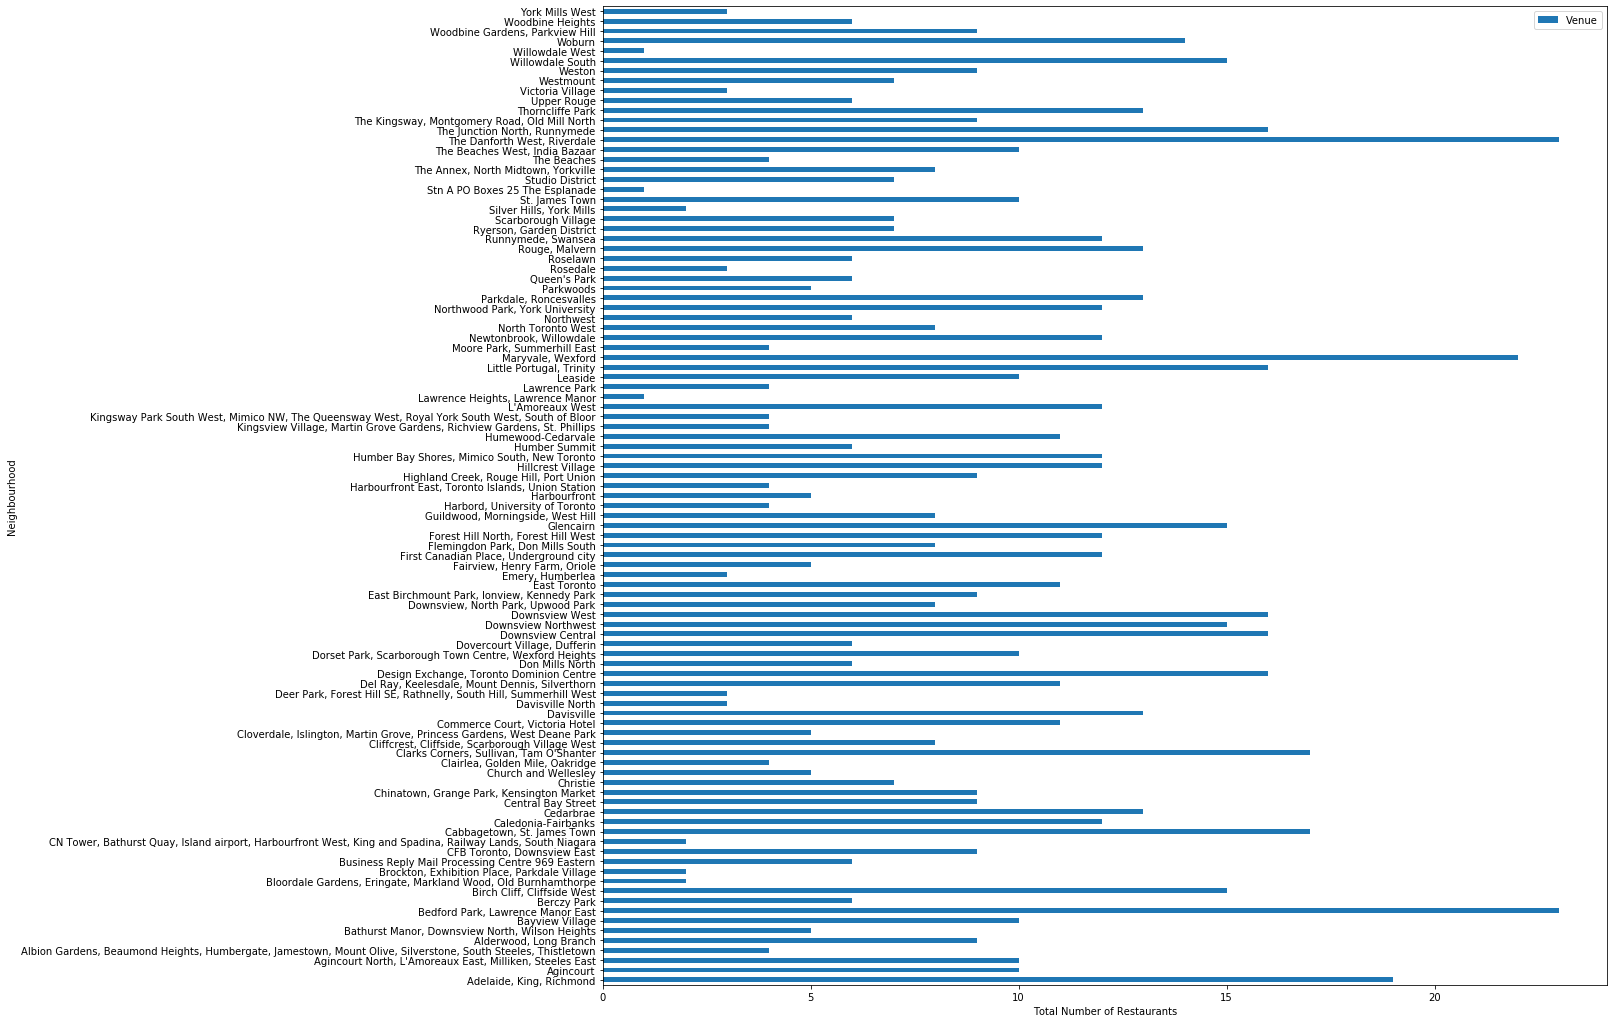

In [1509]:
Toronto_neigh_restaurants_count[['Venue']].plot(kind='barh', figsize = (18,18))
plt.xlabel('Total Number of Restaurants')

plt.show()

__Creating a dataframe for the number of restaurants per neighbourhood__

In [1510]:
Restaurants_per_neigh = Toronto_neigh_restaurants_count.reset_index()[['Neighbourhood', 'Venue']].join(Toronto_df.set_index('Neighbourhood'), on='Neighbourhood').rename(columns = {'Venue' : 'Restaurants'}).dropna().reset_index(drop=True)
Restaurants_per_neigh

Neighbourhood  Restaurants  \
0                            Adelaide, King, Richmond           19   
1                                           Agincourt           10   
2   Agincourt North, L'Amoreaux East, Milliken, St...           10   
3   Albion Gardens, Beaumond Heights, Humbergate, ...            4   
4                              Alderwood, Long Branch            9   
..                                                ...          ...   
94                                    Willowdale West            1   
95                                             Woburn           14   
96                    Woodbine Gardens, Parkview Hill            9   
97                                   Woodbine Heights            6   
98                                    York Mills West            3   

   Postal Code           Borough   Latitude  Longitude  Population, 2016  
0          M5H  Downtown Toronto  43.650571 -79.384568            2005.0  
1          M1S       Scarborough  43.794200 -79.262029           37769.0  
2          M1V       Scarborough  43.815252 -79.284577           54680.0  
3          M9V         Etobicoke  43.739416 -79.588437           55959.0  
4          M8W         Etobicoke  43.602414 -79.543484           20674.0  
..         ...               ...        ...        ...               ...  
94         M2R        North York  43.782736 -79.442259           40792.0  
95         M1G       Scarborough  43.770992 -79.216917           29690.0  
96         M4B         East York  43.706397 -79.309937           18628.0  
97         M4C         East York  43.695344 -79.318389           46866.0  
98         M2P        North York  43.752758 -79.400049            7843.0  

[99 rows x 7 columns]

__A choropleth map to visualize the number of restaurants in each neighbourhood__

In [1511]:
map_Toronto_Ontario = folium.Map(location=[latitude, longitude], zoom_start=10)
Toronto_geo = 'Data/Toronto_geo.geojson'
threshold_scale = np.linspace(Restaurants_per_neigh['Restaurants'].min(), Restaurants_per_neigh['Restaurants'].max(), 6, dtype = int).tolist()
threshold_scale[-1] = threshold_scale[-1] + 1

map_Toronto_Ontario.choropleth(
    geo_data=Toronto_geo,
    data=Restaurants_per_neigh,
    columns=['Postal Code', 'Restaurants'],
    key_on='feature.properties.CFSAUID',
    threshold_scale = threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of Restaurants in each Neighbourhood'
)

for lat, lng, borough, neighborhood, pop in zip(Restaurants_per_neigh['Latitude'], Restaurants_per_neigh['Longitude'], Restaurants_per_neigh['Borough'], Restaurants_per_neigh['Neighbourhood'], Restaurants_per_neigh['Restaurants']):
    label = '{}, {} - No. of Restaurants = {}'.format(neighborhood, borough, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.0,
        parse_html=False).add_to(map_Toronto_Ontario) 

map_Toronto_Ontario

__A choropleth map to visualize the population in each neighbourhood__

In [1512]:
map_Toronto_Ontario = folium.Map(location=[latitude, longitude], zoom_start=10)
Toronto_geo = 'Data/Toronto_geo.geojson'
threshold_scale = np.linspace(Toronto_df['Population, 2016'].min(), Toronto_df['Population, 2016'].max(), 6, dtype = int).tolist()
threshold_scale[-1] = threshold_scale[-1] + 1

map_Toronto_Ontario.choropleth(
    geo_data=Toronto_geo,
    data=Toronto_df,
    columns=['Postal Code', 'Population, 2016'],
    key_on='feature.properties.CFSAUID',
    threshold_scale = threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population of Toronto, Ontario'
)

for lat, lng, borough, neighborhood, pop in zip(Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Borough'], Toronto_df['Neighbourhood'], Toronto_df['Population, 2016']):
    label = '{}, {} - Population = {}'.format(neighborhood, borough, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.0,
        parse_html=False).add_to(map_Toronto_Ontario) 

# display map
map_Toronto_Ontario

__A simple way to explore whether there are sufficient resturants in each neighbourhood to serve all the people living there is by dividing the population number by the number of restaurants in each neighbourhood. This will give us a percentage that shows the need for more resutrants in each neighbourhood.__

In [1513]:
min_max_scaler = preprocessing.MinMaxScaler()
Restaurants_per_neigh['Ratio_pop_neigh'] = min_max_scaler.fit_transform((Restaurants_per_neigh['Population, 2016']/Restaurants_per_neigh['Restaurants']).values.reshape(-1,1).astype(float)) * 100
Restaurants_per_neigh

Neighbourhood  Restaurants  \
0                            Adelaide, King, Richmond           19   
1                                           Agincourt           10   
2   Agincourt North, L'Amoreaux East, Milliken, St...           10   
3   Albion Gardens, Beaumond Heights, Humbergate, ...            4   
4                              Alderwood, Long Branch            9   
..                                                ...          ...   
94                                    Willowdale West            1   
95                                             Woburn           14   
96                    Woodbine Gardens, Parkview Hill            9   
97                                   Woodbine Heights            6   
98                                    York Mills West            3   

   Postal Code           Borough   Latitude  Longitude  Population, 2016  \
0          M5H  Downtown Toronto  43.650571 -79.384568            2005.0   
1          M1S       Scarborough  43.794200 -79.262029           37769.0   
2          M1V       Scarborough  43.815252 -79.284577           54680.0   
3          M9V         Etobicoke  43.739416 -79.588437           55959.0   
4          M8W         Etobicoke  43.602414 -79.543484           20674.0   
..         ...               ...        ...        ...               ...   
94         M2R        North York  43.782736 -79.442259           40792.0   
95         M1G       Scarborough  43.770992 -79.216917           29690.0   
96         M4B         East York  43.706397 -79.309937           18628.0   
97         M4C         East York  43.695344 -79.318389           46866.0   
98         M2P        North York  43.752758 -79.400049            7843.0   

    Ratio_pop_neigh  
0          0.258694  
1          9.258923  
2         13.404589  
3         34.295328  
4          5.631278  
..              ...  
94       100.000000  
95         5.198849  
96         5.073980  
97        19.148362  
98         6.408936  

[99 rows x 8 columns]

__It looks like Willowdale West is very low on the number of restaurants.__

In [1514]:
map_Toronto_Ontario = folium.Map(location=[latitude, longitude], zoom_start=10)
Toronto_geo = 'Data/Toronto_geo.geojson'
threshold_scale = np.linspace(Restaurants_per_neigh['Ratio_pop_neigh'].min(), Restaurants_per_neigh['Ratio_pop_neigh'].max(), 6, dtype = int).tolist()
threshold_scale[-1] = threshold_scale[-1] + 1

map_Toronto_Ontario.choropleth(
    geo_data=Toronto_geo,
    data=Restaurants_per_neigh,
    columns=['Postal Code', 'Ratio_pop_neigh'],
    key_on='feature.properties.CFSAUID',
    threshold_scale = threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Ratio of the Population per No. of Restaurants'
)

for lat, lng, borough, neighborhood, ratio in zip(Restaurants_per_neigh['Latitude'], Restaurants_per_neigh['Longitude'], Restaurants_per_neigh['Borough'], Restaurants_per_neigh['Neighbourhood'], Restaurants_per_neigh['Ratio_pop_neigh']):
    label = '{}, {} - Ratio = {}\%'.format(neighborhood, borough, round(ratio,2))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.0,
        parse_html=False).add_to(map_Toronto_Ontario) 

map_Toronto_Ontario

__Let's see the population of Willowdale West and the restaurants there.__

In [1515]:
Restaurants_per_neigh[Restaurants_per_neigh['Neighbourhood'] =='Willowdale West']

Neighbourhood  Restaurants Postal Code     Borough   Latitude  \
94  Willowdale West            1         M2R  North York  43.782736   

    Longitude  Population, 2016  Ratio_pop_neigh  
94 -79.442259           40792.0            100.0

__McDonald's is the only restaurant there. <br />
--> Alhough there could be more restaurants in that area but they are not in the Foursquare database, this could be a very good location to start a new restaurant.__

In [1516]:
Toronto_restaurants[Toronto_restaurants['Neighbourhood'] == 'Willowdale West']

Neighbourhood  Neighborhood Latitude  Neighborhood Longitude  \
657  Willowdale West              43.782736              -79.442259   

                     Venue_ID       Venue  Venue Latitude  Venue Longitude  \
657  4ba430fcf964a520968a38e3  McDonald's       43.789853       -79.446541   

     Distance        Venue Category  Rating  Likes  Price  Tips Postal Code  \
657       863  Fast Food Restaurant     5.2     17    1.0    13         M2R   

        Borough  Population, 2016  
657  North York           40792.0

# 3. Machine Learning

__Using DBSCAN to cluster the restaurants based on their location. That can give us an idea about the high density resturant locations.__ 

In [1535]:
Clus_dataSet = Toronto_restaurants[['Venue Latitude','Venue Longitude']]
Clus_dataSet = preprocessing.StandardScaler().fit_transform(Clus_dataSet)

db = DBSCAN(eps=0.3, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
Toronto_restaurants["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

print(Toronto_restaurants['Clus_Db'].unique())
Toronto_restaurants.head(10)


map_Toronto_Ontario = folium.Map(location=[latitude, longitude], zoom_start=10)
Toronto_geo = 'Data/Toronto_geo.geojson'


colo = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))
colo_hex = []
for i in range(clusterNum):
    colo_hex.append(colors.to_hex(colo[i]))
 

for lat, lng, label, boro, neigh in zip(Toronto_restaurants['Venue Latitude'], Toronto_restaurants['Venue Longitude'], Toronto_restaurants['Clus_Db'], Toronto_restaurants['Borough'], Toronto_restaurants['Neighbourhood']):
    c=(('#808080') if label == -1 else colo_hex[np.int(label)])
    popuplabel = '{}, {} - Cluster: {}'.format(neigh, boro, label)
    popuplabel = folium.Popup(popuplabel, parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        popup=popuplabel,
        radius=5, 
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=1.0
    ).add_to(map_Toronto_Ontario)


for clust_number in  set(Toronto_restaurants['Clus_Db']):
    c=(('#808080') if clust_number == -1 else colo_hex[np.int(clust_number)])
    clust_set = Toronto_restaurants[Toronto_restaurants['Clus_Db'] == clust_number]
    if clust_number != -1:
        cenx=np.mean(clust_set['Venue Latitude']) 
        ceny=np.mean(clust_set['Venue Longitude']) 

        folium.map.Marker(
            [cenx, ceny],
            icon=DivIcon(
                icon_size=(150,36),
                icon_anchor=(0,0),
                html='<div style="font-size: 24pt">' + str(clust_number) + '</div>',
            )
        ).add_to(map_Toronto_Ontario)
    


# show map
map_Toronto_Ontario

[ 0  1  2 -1  3  4  5  6  7  8  9 10]


In [ ]:
#        print('Cluster ' + str(clust_number) + ', Avg Rating: ' + str(round(np.mean(clust_set['Rating']),2))
#                                             + ', Avg Likes: ' + str(round(np.mean(clust_set['Likes']),2)) 
#                                             + ', Avg Tips: ' + str(round(np.mean(clust_set['Tips']),2))
#                                             + ', Avg Price: ' + str(round(np.mean(clust_set['Price']),2))
#                                             + ', Avg Distance: ' + str(round(np.mean(clust_set['Distance']),2))
#             )

In [1542]:
Clus_dataSet = Toronto_restaurants[['Venue Latitude','Venue Longitude', 'Rating', 'Likes', 'Tips', 'Price']]
Clus_dataSet = preprocessing.StandardScaler().fit_transform(Clus_dataSet)

db = DBSCAN(eps=0.6, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
Toronto_restaurants["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

print(Toronto_restaurants['Clus_Db'].unique())
Toronto_restaurants.head(10)


map_Toronto_Ontario = folium.Map(location=[latitude, longitude], zoom_start=10)
Toronto_geo = 'Data/Toronto_geo.geojson'


colo = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))
colo_hex = []
for i in range(clusterNum):
    colo_hex.append(colors.to_hex(colo[i]))
 

for lat, lng, label, boro, neigh in zip(Toronto_restaurants['Venue Latitude'], Toronto_restaurants['Venue Longitude'], Toronto_restaurants['Clus_Db'], Toronto_restaurants['Borough'], Toronto_restaurants['Neighbourhood']):
    c=(('#808080') if label == -1 else colo_hex[np.int(label)])
    popuplabel = '{}, {} - Cluster: {}'.format(neigh, boro, label)
    popuplabel = folium.Popup(popuplabel, parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        popup=popuplabel,
        radius=5, 
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=1.0
    ).add_to(map_Toronto_Ontario)


for clust_number in  set(Toronto_restaurants['Clus_Db']):
    c=(('#808080') if clust_number == -1 else colo_hex[np.int(clust_number)])
    clust_set = Toronto_restaurants[Toronto_restaurants['Clus_Db'] == clust_number]
    if clust_number != -1:
        cenx=np.mean(clust_set['Venue Latitude']) 
        ceny=np.mean(clust_set['Venue Longitude']) 

        folium.map.Marker(
            [cenx, ceny],
            icon=DivIcon(
                icon_size=(150,36),
                icon_anchor=(0,0),
                html='<div style="font-size: 24pt">' + str(clust_number) + '</div>',
            )
        ).add_to(map_Toronto_Ontario)
        
        print('Cluster ' + str(clust_number) + ', Avg Rating: ' + str(round(np.mean(clust_set['Rating']),2))
                                             + ', Avg Likes: ' + str(round(np.mean(clust_set['Likes']),2)) 
                                             + ', Avg Tips: ' + str(round(np.mean(clust_set['Tips']),2))                                           
                                             + ', Avg Price: ' + str(round(np.mean(clust_set['Price']),2))
                                            
             )
    


# show map
map_Toronto_Ontario

[-1  0  3  1  4  2]
Cluster 0, Avg Rating: 6.83, Avg Likes: 1.51, Avg Tips: 1.03, Avg Price: 2.0
Cluster 1, Avg Rating: 6.49, Avg Likes: 1.4, Avg Tips: 0.53, Avg Price: 2.0
Cluster 2, Avg Rating: 7.42, Avg Likes: 0.0, Avg Tips: 0.0, Avg Price: 2.0
Cluster 3, Avg Rating: 5.12, Avg Likes: 0.6, Avg Tips: 0.3, Avg Price: 2.0
Cluster 4, Avg Rating: 6.92, Avg Likes: 1.9, Avg Tips: 1.2, Avg Price: 1.0
